# Introduction to GANs

This Jupyter notebook will walk you through building a simple GAN model and training it on the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) using [PyTorch](https://pytorch.org/). PyTorch is a very powerful library written in Python and C++ that facilitates the building and training of neural networks.

You can create a copy of this Jupyter notebook by clicking the **File** toolbar and selecting **Save a copy in Drive**, as shown below:

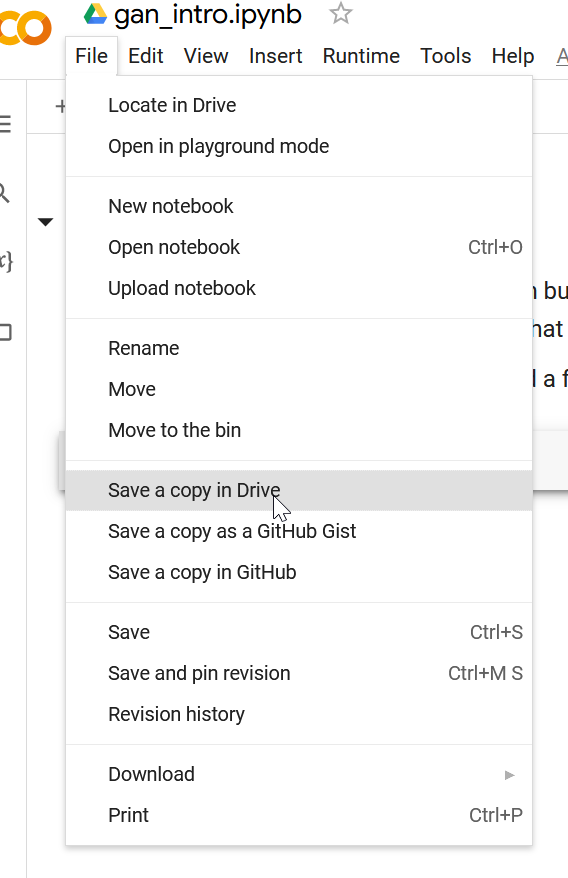

# Getting Started

To start, we will need to import PyTorch and a few other libraries we're going to use for this demonstration.

In [ ]:
import os
import time

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.utils import make_grid, save_image

Google Colabratory provides GPU resources for simple demonstrations such as these, however **they must be requested first**.

We can do that by going to the **Runtime** menu and selecting **Change runtime type**, as shown below:

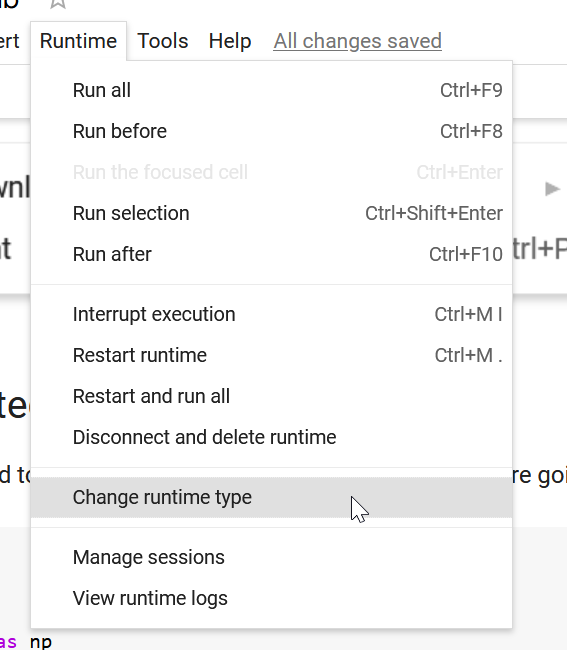

Once you have done this, the following menu should appear:

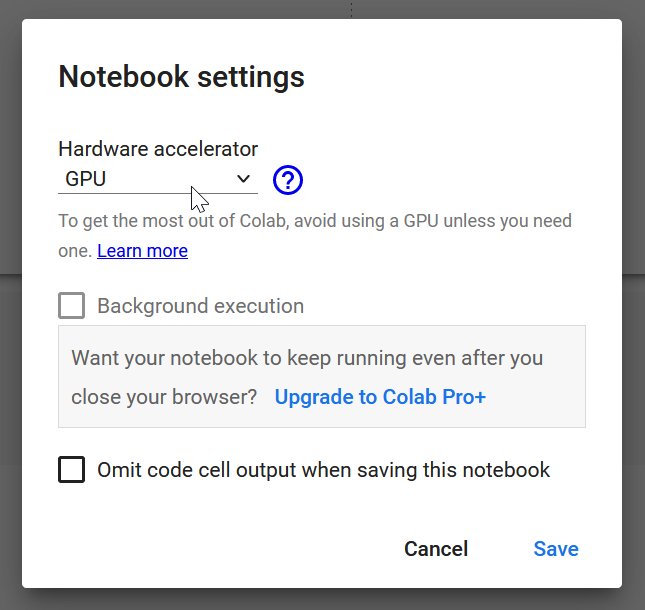

Set the **Hardware accelerator** to **GPU** and click **Save**.

Let's check what compute resources we have now. Google Colabratory *should* have hopefully provided us with a GPU now.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(device))
else:
  print("No GPU available. :(")

Tesla K80


If you get an error here, you may need to rerun the previous code cells, then try again.

Now we hopefully have a GPU, let's define paths to save our dataset and image sample outputs to, and then ensure they're created. Note that this data is not stored permanently, so if you wish to save these files to your Google Drive have a look at [this tutorial](https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/).

In [ ]:
dataset_path = os.path.join(os.getcwd(), "data")
image_path = os.path.join(os.getcwd(), "images")

# Ensure both of the directories are created.
if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

if not os.path.exists(image_path):
    os.mkdir(image_path)

# Loading our data

With the file storage out of the way, we can define a few variables. Firstly, we need to set our batch size.

In [ ]:
batch_size = 128

Next let's create a transform that normalises the pixels in our image to be within the range of -1 to 1. This helps the neural network to train better than leaving the inputs unnormalised.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,), (.5,))])

We can now load our data. As mentioned above, we're using the MNIST dataset. It's a very simple dataset of 28x28 greyscale images containing handwritten digits from 0 to 9. It has been used as a benchmark since the early days of machine learning, and is simple enough that we can train a GAN on it quite quickly, despite consisting of around 60,000 samples!

PyTorch contains the MNIST dataset as a baseline, so we can just use their preformed dataset to download the data.

In [ ]:
mnist_dataset = datasets.MNIST(root=os.path.join(os.getcwd(), "data"), train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



PyTorch uses a DataLoader wrapper around a dataset in order to iterate through the dataset. It's where we specify the number of samples per batch, as well as whether to shuffle the data. drop_last ensures that any batch that isn't at least 128 samples gets dropped.

In [ ]:
mnist_data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Let's confirm how many image samples we have, as well as get a sample of images to show.

Dataset size: 60000 images.


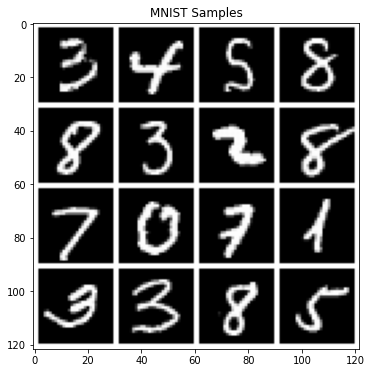

In [ ]:
print(f'Dataset size: {len(mnist_dataset)} images.')

# Get a batch from the dataloader and take 16 images from that batch to display.
batch = next(iter(mnist_data_loader))
img_batch = batch[0]
img_batch_subset = img_batch[:16]  # extract only a subset of images

# Form a grid of images and display them.
grid = make_grid(img_batch_subset, nrow=int(4), normalize=True, pad_value=1.)

# Rearrange axis from channels first to channels last for MatPlotLib.
grid = np.moveaxis(grid.numpy(), 0, 2)

# Plot our figure.
plt.figure(figsize=(6, 6))
plt.title("MNIST Samples")
plt.imshow(grid)
plt.show()

Now we have seen our data, we can start building our neural network!

# Building the GAN!

Recall that the generator has a latent space from which we draw samples from by input random vectors. Let's define it as a vector with 100 elements and create a function to generate a batch of latent inputs.

In [ ]:
LATENT_SPACE_DIM = 100

def get_gaussian_latent_batch(batch_size, device):
    return torch.randn((batch_size, LATENT_SPACE_DIM), device=device)

We can now start constructing our neural networks. Remember that generative adversarial networks are actually composed of two networks: a generator and a discriminator.

Let's create a building block for constructing the networks first:

In [ ]:
def network_block(in_feat, out_feat, normalize=True, activation=None):
    layers = [nn.Linear(in_feat, out_feat)]
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat))

    layers.append(nn.LeakyReLU(0.2) if activation is None else activation)

    return layers

This building block consists of a Linear (or fully connected) layer, a batch normalisation layer and an activation function layer (Leaky ReLU).

Using this block, let's now build our generator, which is tasked with creating new MNIST samples:

In [ ]:
class GeneratorNet(torch.nn.Module):
    def __init__(self, img_shape=(28, 28)):
        super().__init__()
        self.generated_img_shape = img_shape
        num_neurons_per_layer = [LATENT_SPACE_DIM, 256, 512, 1024, img_shape[0] * img_shape[1]]

        # Let's define our network as a series of four of the blocks we defined above. Each time we increase the
        # number of neurons per layer and use the leaky ReLU as our activation function. For the last set of layers,
        # we skip normalisation and instead apply a hyperbolic tangent as our activation layer. This is so that the
        # output of the network is in the range of -1 to 1, with the same number of pixels as the inputs.
        self.net = nn.Sequential(
            *network_block(num_neurons_per_layer[0], num_neurons_per_layer[1]),
            *network_block(num_neurons_per_layer[1], num_neurons_per_layer[2]),
            *network_block(num_neurons_per_layer[2], num_neurons_per_layer[3]),
            *network_block(num_neurons_per_layer[3], num_neurons_per_layer[4], normalize=False, activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch):
        img_batch_flattened = self.net(latent_vector_batch)

        # The output of the network is a vector of 784 pixels, let's reshape it so it's a matrix of 28x28 pixels.
        return img_batch_flattened.view(img_batch_flattened.shape[0], 1, *self.generated_img_shape)

The above generator is built using four of the network blocks we defined above, each time increase the number of neurons per layer. The final block uses a hyperbolic tangent as its activation function, as this allows us to shape the output in the range of -1 to 1, which is the range our pixels are stored in.

Next, we'll define the discriminator in a similar manner:

In [ ]:
class DiscriminatorNet(torch.nn.Module):
    def __init__(self, img_shape=(28, 28)):
        super().__init__()
        num_neurons_per_layer = [img_shape[0] * img_shape[1], 512, 256, 1]

        # Last layer is Sigmoid function - basically the goal of the discriminator is to output 1.
        # for real images and 0. for fake images and sigmoid is clamped between 0 and 1 so it's perfect.
        self.net = nn.Sequential(
            *network_block(num_neurons_per_layer[0], num_neurons_per_layer[1], normalize=False),
            *network_block(num_neurons_per_layer[1], num_neurons_per_layer[2], normalize=False),
            *network_block(num_neurons_per_layer[2], num_neurons_per_layer[3], normalize=False, activation=nn.Sigmoid())
        )

    def forward(self, img_batch):
        # We remove the redundant channel dimension here, since it's of size 1 (we're dealing with greyscale images
        # remember).
        img_batch_flattened = img_batch.view(img_batch.shape[0], -1)
        return self.net(img_batch_flattened)

We use the same block we created for the generator to keep things simple, and just reverse the process: going from an image of 28x28 to a single floating point number representing the certainty that the discriminator has of a sample being real or generated.

Now we've defined our generator and discriminator, all that remains is to create them!

In [ ]:
# We send both networks to our training device, hopefully a GPU if Colab was feeling generous!
discriminator_net = DiscriminatorNet().to(device)
generator_net = GeneratorNet().to(device)

# Make sure they're both set to train!
discriminator_net.train()
generator_net.train()


GeneratorNet(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

# Preparing to train

Now we've created our generator and discriminator, we need to train them! As it stands, they've been initiated with random weights for all trainable parameters. This means that initially, both the generator and discriminator are going to be terrible at their respective tasks.

By training them, both will improve, and through the adversarial nature of the loss function, one network getting stronger *should* result in the other improving too. This isn't always the case however, sometimes either the generator or discriminator will become too strong and overpower the other. This is a failure case, and the model will no longer produce anything meaningful.

In the case of the generator winning, it learns a pattern that fools the discriminator while not necessarily representing the dataset at all. Often, the mode will collpase, with all latent variables converging to the same output image. If the discriminator wins, the generator loses its gradient and will begin to produce garbage outputs.

We want to avoid both cases, which makes GANs more difficult to train than most other machine learning models.

To begin our training, we first need to create an optimiser for each network. This optimiser implements an algorithm for performing backpropagation on the neural network. For this demo, we'll use the well known and effective Adam optimiser. If you want to know more about how this works, the paper it was proposed in can be found [here](https://arxiv.org/abs/1412.6980).

In [ ]:
discriminator_opt = Adam(discriminator_net.parameters(), lr=0.0002)
generator_opt = Adam(generator_net.parameters(), lr=0.0002)

We set the initial learning rate for both optimisers to 0.0002. The learning rate is the single most important hyperparameter when training, and changing it can have drastic results. Try experimenting with much larger learning rates on both the generator and discriminator and see how it affects training!

In order to evaluate how the network is doing, we'll use a constant set of 16 latent inputs and monitor how the outputs change, saving a sample to the images directory on Colab's temporary storage.

In [ ]:
ref_batch_size = 16
ref_noise_batch = get_gaussian_latent_batch(ref_batch_size, device)

We need to define the loss function that we're going to use to train our networks. We'll use binary cross entropy to measure our discriminator's predictions.

If we input real images into the discriminator we expect it to output 1 (100% certainty that the image is real).

The further away it is from 1 and the closer it is to 0 the more we should penalize it, as it is making an incorrect prediction.

BCE loss essentially becomes -log(x) when the target label is 1.

Similarly for fake images, the target label is 0 (as we want the discriminator to output 0 for fake images) and we want to penalise the generator if it starts outputing values close to 1. So we basically want to mirror the above loss function and that's just: -log(1-x).

BCE loss basically becomes -log(1-x) when it's target label is 0.

In [ ]:
adversarial_loss = nn.BCELoss()

# Let's define our ground truth for each type of input.
real_images_gt = torch.ones((batch_size, 1), device=device)
fake_images_gt = torch.zeros((batch_size, 1), device=device)

Finally, let's define a few variables to help our training process.

In [ ]:
# Let's create some variables to keep track of our losses, as well as configure how often we log.
discriminator_loss_values = []
generator_loss_values = []
img_count = 0
console_log_freq = 50
debug_imagery_log_freq = 50

# This defines how many times we show the entire dataset to each network. 100 epochs means we show the networks every
# sample 100 times. Feel free to experiment with this and see if it affects training!
num_epochs = 100

# Let's also measure how much time training takes.
start_time = time.time()

We're now ready to begin our training loop!

# Starting the training

Let's create our GAN training loop. We start with training the discriminator, as this helps to prevent early mode collapse. For 100 epochs, this training will take approximately 20-25 minutes, go grab a coffee! :)

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(mnist_data_loader):

        # Move the batch tensor to our training device.
        real_images = real_images.to(device)

        # Zero out the gradients in the discriminator. It's essential to do this prior to performing a forward and
        # backwards pass, else we have stale gradients from the previous iteration still present.
        discriminator_opt.zero_grad()

        # Show real images to our discriminator.
        real_discriminator_loss = adversarial_loss(discriminator_net(real_images), real_images_gt)

        # Generate fake images with the generator.
        fake_images = generator_net(get_gaussian_latent_batch(batch_size, device))

        # Show fake images to our discriminator. We call .detach() on them to detach them from the gradient graph
        # since we're not training the generator right now.
        fake_discriminator_loss = adversarial_loss(discriminator_net(fake_images.detach()), fake_images_gt)

        # Calculate the final loss by adding both terms and performing a backpropagation pass and optimiser step.
        discriminator_loss = real_discriminator_loss + fake_discriminator_loss
        discriminator_loss.backward()
        discriminator_opt.step()

        # Zero out the gradients in the generator.
        generator_opt.zero_grad()

        # Generate fake images and show them to the discriminator.
        generated_images_predictions = discriminator_net(generator_net(get_gaussian_latent_batch(batch_size, device)))

        # The generator's goal is to fool the discriminator, so our loss function should aim to make the
        # discriminator classify these fake images as real.
        generator_loss = adversarial_loss(generated_images_predictions, real_images_gt)

        # Perform a backpropagation pass and optimiser step.
        generator_loss.backward()  # this will populate .grad vars in the G net (also in D but we won't use those)
        generator_opt.step()  # perform G weights update according to optimizer's strategy

        # Log our loss values. We detach them from the graph to ensure we don't get a memory leak.
        generator_loss_values.append(generator_loss.detach().item())
        discriminator_loss_values.append(discriminator_loss.detach().item())

        # Log details to the console.
        if batch_idx % console_log_freq == 0:
            prefix = 'GAN training: time elapsed'
            print(f"{prefix} = {(time.time() - start_time):.2f} [s] | epoch={epoch + 1} | "
                  f"batch= [{batch_idx + 1}/{len(mnist_data_loader)}]")

        # Save intermediate generator images.
        if batch_idx % debug_imagery_log_freq == 0:
            with torch.no_grad():
                log_generated_images = generator_net(ref_noise_batch)
                log_generated_images_resized = nn.Upsample(scale_factor=2.5, mode='nearest')(log_generated_images)
                out_path = os.path.join(image_path, f'{str(img_count).zfill(6)}.jpg')
                save_image(log_generated_images_resized, out_path, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                img_count += 1

GAN training: time elapsed = 0.38 [s] | epoch=1 | batch= [1/468]
GAN training: time elapsed = 4.91 [s] | epoch=1 | batch= [51/468]
GAN training: time elapsed = 7.16 [s] | epoch=1 | batch= [101/468]
GAN training: time elapsed = 9.42 [s] | epoch=1 | batch= [151/468]
GAN training: time elapsed = 11.68 [s] | epoch=1 | batch= [201/468]
GAN training: time elapsed = 13.89 [s] | epoch=1 | batch= [251/468]
GAN training: time elapsed = 16.10 [s] | epoch=1 | batch= [301/468]
GAN training: time elapsed = 18.33 [s] | epoch=1 | batch= [351/468]
GAN training: time elapsed = 20.56 [s] | epoch=1 | batch= [401/468]
GAN training: time elapsed = 22.85 [s] | epoch=1 | batch= [451/468]
GAN training: time elapsed = 23.67 [s] | epoch=2 | batch= [1/468]
GAN training: time elapsed = 25.88 [s] | epoch=2 | batch= [51/468]
GAN training: time elapsed = 28.13 [s] | epoch=2 | batch= [101/468]
GAN training: time elapsed = 30.37 [s] | epoch=2 | batch= [151/468]
GAN training: time elapsed = 32.60 [s] | epoch=2 | batch= 

Now our training is finished, it's time to evaluate how it's doing!

If you'd like, you can check out the image samples we saved during training. Remember we created a set of constant latent inputs, meaning each image has the same input and differs only because the generator's weights have updated.

To check the local files on Google Colabratory, click the folder icon on the side, as shown below:

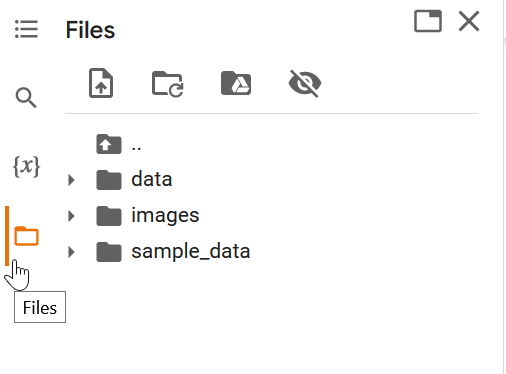

The images folder contains samples produced as training has progressed. Can you see how it's improving over time?

# Evaluating our GAN

Now we've trained our model, we can use it to generate a new handwritten digit based on the MNIST dataset, but totally unique!

To start with, we'll define a few functions for prettying up and displaying the sample images.

In [ ]:
def postprocess_generated_img(generated_img_tensor):
    assert isinstance(generated_img_tensor, torch.Tensor), f'Expected PyTorch tensor but got {type(generated_img_tensor)}.'

    # Move the tensor from GPU to CPU, convert to numpy array, extract 0th batch, move the image channel
    # from 0th to 2nd position (CHW -> HWC)
    generated_img = np.moveaxis(generated_img_tensor.to('cpu').numpy()[0], 0, 2)

    # Since MNIST images are grayscale (1-channel only) repeat 3 times to get RGB image
    generated_img = np.repeat(generated_img,  3, axis=2)

    # Normalise from range of [-1, 1], to [0, 1].
    generated_img -= np.min(generated_img)
    generated_img /= np.max(generated_img)

    return generated_img


# This function will generate a random vector pass it to the generator which will generate a new image
# which we will just post-process and return it
def generate_from_random_latent_vector(generator):
    with torch.no_grad():  # Tells PyTorch not to compute gradients which would have huge memory footprint

        # Generate a single random (latent) vector
        latent_vector = get_gaussian_latent_batch(1, next(generator.parameters()).device)

        # Post process generator output (as it's in the [-1, 1] range, remember?)
        generated_img = postprocess_generated_img(generator(latent_vector))

    return generated_img


def display_image(numpy_image):
    assert isinstance(numpy_image, np.ndarray), f'Expected numpy array got {type(numpy_image)}.'

    # Convert to uint8 format if it isn't already.
    if numpy_image.dtype != np.uint8:
        numpy_image = (numpy_image*255).astype(np.uint8)

    # Show the image.
    plt.imshow(numpy_image)
    plt.show()

Now let's generate a sample image from our generator! First we need to set the generator to evaluation mode, to prevent PyTorch from generating gradients.

In [ ]:
generator_net.eval()

GeneratorNet(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

Finally, let's generate our new sample! :)

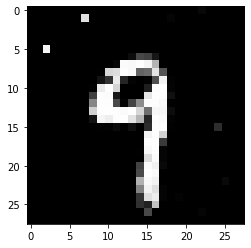

In [ ]:
generated_img = generate_from_random_latent_vector(generator_net)
display_image(generated_img)

You can rerun the above cell multiple times to generate new, unique samples.

I hope this tutorial was helpful! Please feel free to experiment with the network architectures or hyperparameters. You could also try and intentionally cause the generator or discriminator to win and see what happens to the output.

Some of the code and explanations from this tutorial came from [this GitHub repository](https://github.com/gordicaleksa/pytorch-gans). It contains some more in-depth explanations, as well as examples of more advanced GAN models than we covered here.

Finally, feel free to email me if you have any questions about using GANs, or how they could be applied to your own research problems! My own research heavily uses them, so I'm quite experienced at debugging and solving issues. You can contact me at sccmho@leeds.ac.uk.